In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Adding KBM value to df
users = pd.read_csv('C:/Users/sgulbin/Work/Analysis/DataQualityAnalysis/original_data/users_activated_v6.csv', low_memory = False)
users = users[['user_id', 'login', 'sex', 'birthday', 'license_set_date']]
kbm = pd.read_csv('C:/Users/sgulbin/Work/Scoring (Accidents)/2020-03Test_v2/KBM_data/KBM_data_4_13_2020.csv')
kirill = pd.read_csv('C:/Users/sgulbin/Work/Analysis/Kirill/otpusk/new_coefs.csv', delimiter = ';')
df = pd.merge(pd.merge(kirill,users,on = 'user_id', how = 'left'), kbm, on = 'user_id', how = 'left')
df['age'] = np.clip((pd.to_datetime('today')-pd.to_datetime(df.birthday, errors = 'coerce')).astype('timedelta64[Y]'),19.0,80.0)
df['exp'] = np.clip((pd.to_datetime('today')-pd.to_datetime(df.license_set_date, errors = 'coerce')).astype('timedelta64[Y]'),1.0,62.0)
df['sex'] = df['sex'].fillna('Unknown')

In [21]:
# Generating age-exp coefficients
K_age_exp_max = 1.2
K_age_exp_min = 0.725
K_intercept = -4.88430556234637
K_f_age = 1.26397937674965
K_f_exp = 0.0762464696907463
f_age_exp_min = K_f_age*np.log(19)+K_f_exp*np.log(1)+K_intercept
f_age_exp_max = K_f_age*np.log(50)+K_f_exp*np.log(20)+K_intercept
K = K_age_exp_max-((K_f_age*np.log(19)+K_f_exp*np.log(1)+K_intercept)-f_age_exp_min)*(K_age_exp_max-K_age_exp_min)/(f_age_exp_max-f_age_exp_min)
ages = []
exps = []
koefs = []
for age in range(19,101):
    for exp in range(1,83):
        K = np.clip(K_age_exp_max-((K_f_age*np.log(age)+K_f_exp*np.log(exp)+K_intercept)-f_age_exp_min)*(K_age_exp_max-K_age_exp_min)/(f_age_exp_max-f_age_exp_min),K_age_exp_min,K_age_exp_max)
        ages.append(age)
        exps.append(exp)
        koefs.append(K)
age_exp_df = pd.DataFrame(data = ({'age':ages, 'exp':exps, 'K_age_exp': koefs}))
# print(age_exp_df)

In [22]:
# Adding coefficients to df
df_K_sex = pd.DataFrame(data = ({'sex': ['М', 'Ж', 'Unknown'], 'K_sex': [1.0,1.10,1.0]}))
df_K_KBM = pd.DataFrame(data = ({'KBM': [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.4,1.55,2.3,2.45,np.nan],
                                 'K_KBM': [0.9,0.9,0.9,0.9,0.9,0.9,0.95,0.95,1.0,1.0,1.03,1.1,1.1,1.1,1.1,1.03]}))
df = pd.merge(df, df_K_sex, how = 'left', left_on = 'sex', right_on = 'sex')
df = pd.merge(df, df_K_KBM, how = 'left', left_on = 'KBM', right_on = 'KBM')
df = pd.merge(df, age_exp_df, how = 'left', left_on = ['age','exp'], right_on = ['age','exp'])
df['K_age_exp'] = np.where(df['age'].isnull(), 1.0, np.where(df['exp'].isnull(),1.0,np.where((df['age']-df['exp'])<16,1.0,df['K_age_exp'])))
df['K_age_exp'] = df['K_age_exp'].fillna(1.0)
df['K_KBM'] = df['K_KBM'].fillna(1.0)

df['K_KBM_model_score'] = np.clip(df.K_sex*df.K_KBM*df.K_age_exp,0.7,1.3)
df['K_KBM_model_score_normalized'] = 100*(df['K_KBM_model_score']-df['K_KBM_model_score'].max())/(df['K_KBM_model_score'].min()-df['K_KBM_model_score'].max())
df['K_KBM_model_score_normalized'] = df['K_KBM_model_score_normalized'].round(0)
df['K_delimobil_score_normalized'] = 100*(df['K_scoring']-df['K_scoring'].max())/(df['K_scoring'].min()-df['K_scoring'].max())
df['K_delimobil_score_normalized'] = df['K_delimobil_score_normalized'].round(0)
df['K_final_score'] = (df['K_KBM_model_score_normalized']*0.2+df['K_delimobil_score_normalized']*0.8).round(0)

In [5]:
dtp = pd.read_excel('C:/Users/sgulbin/Work/_Выгрузки_и_Расчеты/accidents_4_10_2020.xlsx')
dtp['Дата и время ДТП'] = np.where(
    dtp['Дата и время ДТП']=='4/18/2020 12:00:00 AM', '3/18/2020 12:00:00 AM', dtp['Дата и время ДТП']
)
dtp['Дата и время ДТП'] = np.where(
    dtp['Дата и время ДТП']=='4/20/2020 12:00:00 AM', '3/20/2020 12:00:00 AM', dtp['Дата и время ДТП']
)
dtp['Дата и время ДТП'] = np.where(
    dtp['Дата и время ДТП']=='5/24/2020 12:00:00 AM', '3/24/2020 12:00:00 AM', dtp['Дата и время ДТП']
)
dtp['Дата и время ДТП'] = np.where(
    dtp['Дата и время ДТП']=='7/23/2020 12:00:00 AM', '3/23/2020 12:00:00 AM', dtp['Дата и время ДТП']
)
dtp['Дата и время ДТП'] = pd.to_datetime(dtp['Дата и время ДТП'], dayfirst=False, errors = 'coerce')
dtp.sort_values('Дата и время ДТП', inplace=True)
dtp['Дата и время ДТП'] = pd.to_datetime(dtp['Дата и время ДТП'])
dtp = dtp[dtp['Телефон водителя'].notnull()]
dtp['Телефон водителя'] = dtp['Телефон водителя'].apply(int)
dtp = dtp[dtp['ТС'].notnull()]
dtp.reset_index(drop=True, inplace = True)
dtp['ТС'] = dtp['ТС'].str.replace(' ', '')
dtp = dtp[['Дата и время ДТП', 'Регион','Телефон водителя', 'Виновность', 'ТС', 'Модель автомобиля', 'POOL', 'Тариф','Ремонт не производился','Тип ДТП', 'Вид страхования', 'Пострадавшие','Сумма по заказ-наряду','Выставлено', 'Страховая компания сумма выплаченная']].rename(columns={
    'Дата и время ДТП': 'dt',
    'Регион': 'region',
    'Телефон водителя': 'phone',
    'Виновность': 'Responsibility',
    'ТС': 'license_plate',
    'Модель автомобиля': 'vehicle_model',
    'POOL': 'pool',
    'Тариф': 'tariff',
    'Ремонт не производился': 'no repair conducted',
    'тип ДТП': 'accident type',
    'Вид страхования': 'insurance type',
    'Пострадавшие': 'injured',
    'Сумма по заказ-наряду': 'target_amount',
    'Выставлено': 'Vystavleno',
    'Страховая компания сумма выплаченная': 'insurance paid sum'
})

In [6]:
dtp19 = dtp.loc[dtp.dt < dt.datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')]
dtp_notnull = dtp19[pd.notnull(dtp19['target_amount'])]
grpd = dtp_notnull.groupby('vehicle_model').mean()
grpd = grpd[['target_amount']]
grpd.columns = ['mean_loss']
dtp19 = pd.merge(dtp19, grpd, on = 'vehicle_model', how = 'left')
dtp19['modeled_loss'] = dtp19['target_amount'].fillna(dtp19['mean_loss'])
repairs = dtp19.groupby('phone').sum()

In [23]:
df['login'] = df['login'].astype(str).str[:11].astype('int64')
df.index = df.login
repairs['login'] = repairs.index
df = pd.merge(df, repairs, on = 'login', how = 'left')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'login' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
rnt_sum = pd.read_csv('C:/Users/sgulbin/Work/_Выгрузки_и_Расчеты/users_rents_sum_v3.csv', engine = 'python')
df = pd.merge(df, rnt_sum, on = 'user_id', how = 'left')
df['modeled_loss'] = df['modeled_loss'].fillna(0)
df['ride_time'] = df['ride_time'].fillna(0)
grpd = df.groupby('K_final_score').sum()
# grpd.to_csv('C:/Users/sgulbin/Work/_Выгрузки_и_Расчеты/losses_distribution_v2.csv')


                    user_id  K_final_score  target_amount  modeled_loss  \
score_range                                                               
0-10           711965565743        11970.0   2.140807e+06  2.693713e+06   
11-20         2272396424984       249085.0   9.564062e+06  1.343600e+07   
21-30         7862587122106      1477182.0   1.154212e+08  1.578798e+08   
31-40         9987267233557      3134361.0   1.385179e+08  2.073744e+08   
41-50        19839454493280      8468619.0   7.014563e+07  1.195580e+08   
51-60        12129898634718      6467951.0   2.698009e+07  4.986997e+07   
61-70        14408247331817      8317800.0   8.980211e+06  1.967244e+07   
71-80         3966576496976      3384968.0   3.349326e+06  7.719773e+06   
81-90         3452709785973      2665289.0   3.660398e+06  6.322587e+06   
91-100         162837591714       110894.0   1.412795e+04  1.512490e+05   

                ride_cost     ride_time  modeled_loss_per_min  EBIT_per_min  
score_range          

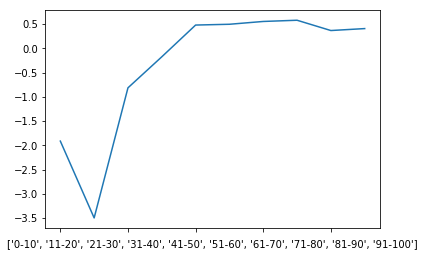

In [12]:
df = df[['user_id', 'K_final_score', 'K_KBM','target_amount', 'modeled_loss', 'ride_cost', 'ride_time']]
lbls = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100']
df['score_range'] = pd.cut(df.K_final_score,10, labels = lbls)
# df['modeled_loss_per_min'] = -df['modeled_loss']/df['ride_time']
# df['net_profit_per_min'] = round(-df['modeled_loss']/df['ride_time']-2.3+df['ride_cost']/df['ride_time'],2)
# df['modeled_loss_per_min'] = df['modeled_loss_per_min'].fillna(0)
# df['net_profit_per_min'] = df['net_profit_per_min'].fillna(0)
grouped = df.groupby('score_range').sum()
grouped2 = df.groupby('score_range').count()
grouped['modeled_loss_per_min'] = -grouped['modeled_loss']/grouped['ride_time']
grouped['EBIT_per_min'] = -grouped['modeled_loss']/grouped['ride_time']-5.87+grouped['ride_cost']/grouped['ride_time']
fig, ax = plt.subplots()
grouped['EBIT_per_min'].plot(ax=ax, kind = 'line')
plt.xlabel(lbls)
print(grouped)
print(grouped2)

# for i in ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100']:
#     dfr = df.loc[df.score_range == i]
#     sns.distplot(dfr.net_profit_per_min)
# sns.distplot(df.net_profit_per_min)
# fig, ax = plt.subplots()
# df['net_profit_per_min'].value_counts().plot(ax=ax, kind='bar')

                    user_id  K_KBM_model_score_normalized  target_amount  \
score_range                                                                
0-10          1804711786558                       60295.0    12670432.81   
11-20         3389861728985                      398103.0    31559362.19   
21-30         7537081045800                     1605805.0    83434408.30   
31-40         8423564423759                     2686288.0    63034250.06   
41-50         9593518316052                     4287626.0    70188979.70   
51-60        10001469543527                     5056274.0    43540656.86   
61-70         9447347846526                     5758197.0    28609375.46   
71-80         9021021863686                     6345026.0    17673291.67   
81-90         7747257401329                     6250332.0    17040714.03   
91-100        7828106724646                     6404465.0    11022355.78   

             modeled_loss     ride_cost     ride_time  modeled_loss_per_min  \
score_ra

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


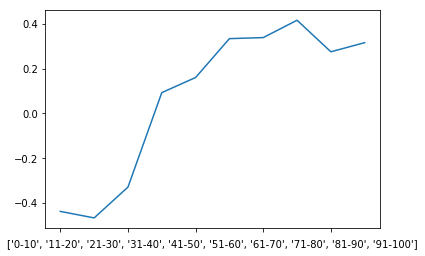

In [26]:
df2 = df[['user_id', 'K_KBM_model_score_normalized','target_amount', 'modeled_loss', 'ride_cost', 'ride_time']]
lbls = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100']
df2['score_range'] = pd.cut(df.K_KBM_model_score_normalized,10, labels = lbls)
grouped = df2.groupby('score_range').sum()
grouped2 = df2.groupby('score_range').count()
grouped['modeled_loss_per_min'] = -grouped['modeled_loss']/grouped['ride_time']
grouped['EBIT_per_min'] = -grouped['modeled_loss']/grouped['ride_time']-5.87+grouped['ride_cost']/grouped['ride_time']
fig, ax = plt.subplots()
grouped['EBIT_per_min'].plot(ax=ax, kind = 'line')
plt.xlabel(lbls)
print(grouped)
print(grouped2)